In [1]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 4) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.5f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

# 7.8.1 Polynomial Regression and Step Functions

In [2]:
wage = pd.read_csv('../datasets/Wage.csv', index_col=0)
wage.iloc[:, 2:10] = wage.iloc[:, 2:10].apply(pd.Categorical)

In [3]:
from sklearn.preprocessing import PolynomialFeatures

pol = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)
polf = pol.fit_transform(wage.loc[:, 'age'].values.reshape(-1, 1))

wage['age_2'] = polf[:,1]
wage['age_3'] = polf[:,2]
wage['age_4'] = polf[:,3]
wage['age_5'] = polf[:,4]

wage['wage_250'] = (wage.wage > 250).map({True: 1, False: 0})

X = wage.loc[:, ['age', 'age_2', 'age_3', 'age_4']]
y = wage.wage

In [4]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(-184.15417977563925,
 array([  2.12455205e+01,  -5.63859313e-01,   6.81068771e-03,
         -3.20383037e-05]))

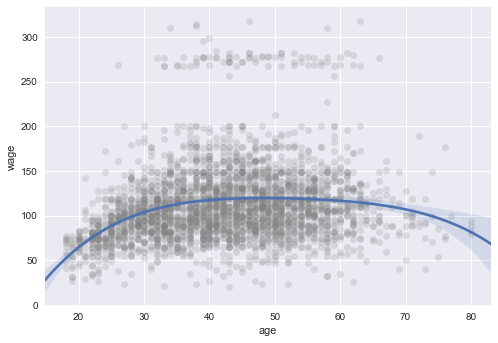

In [5]:
# Easy to plot higher polynomial order regressions from seaborn

sns.regplot(x='age', y='wage', data=wage, order=4, 
            scatter_kws={'alpha': 0.2, 'color': 'gray', 'facecolor': None});

In [6]:
# ANOVA

import statsmodels.api as sm
from statsmodels.formula.api import ols

lin_reg_sm = ols(formula='wage ~ age + age_2 + age_3 + age_4 + age_5', data=wage).fit()
anova_sm = sm.stats.anova_lm(lin_reg_sm, typ=1) # Type 1 for compatibility with the book

anova_sm

/Users/emredjan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/emredjan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/emredjan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/emredjan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
age,1.00000,"199,869.66497","199,869.66497",125.44432,0.00000
age_2,1.00000,"228,786.01013","228,786.01013",143.59311,0.00000
age_3,1.00000,"15,755.69366","15,755.69366",9.88876,0.00168
age_4,1.00000,"6,070.15212","6,070.15212",3.80981,0.05105
age_5,1.00000,"1,282.56302","1,282.56302",0.80498,0.36968
Residual,"2,994.00000","4,770,321.68581","1,593.29382",nan,nan


In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(fit_intercept=True, C=1e9)
log_reg.fit(X, wage.wage_250)

log_reg.intercept_, log_reg.coef_

(array([ -5.19713239e-05]),
 array([[ -1.00531951e-03,  -1.38563574e-02,   4.21914982e-04,
          -3.41220408e-06]]))

In [8]:
# only way to get R compatible results from logistic regression? why?

from statsmodels.formula.api import glm

lr_sm = glm(formula='wage_250 ~ age + age_2 + age_3 + age_4', 
            data=wage,
            family=sm.families.Binomial(sm.families.links.logit)).fit()

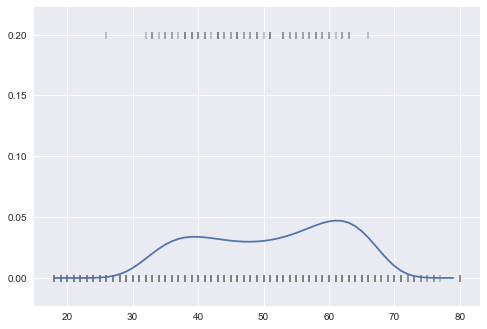

In [9]:
age_grid = np.arange(wage.age.min(), wage.age.max()).reshape(-1,1)

X_test = pd.DataFrame(PolynomialFeatures(4, include_bias=True).fit_transform(age_grid),
                      columns=['Intercept', 'age', 'age_2', 'age_3', 'age_4'])

log_reg_pred = lr_sm.predict(X_test)

plt.scatter(wage.age, wage.wage_250/5, marker='|', color='gray', alpha=0.5)
plt.plot(age_grid, log_reg_pred);

In [61]:
age_step, bins = pd.cut(wage.age, 4, retbins=True, right=True)
bins

array([ 17.938,  33.5  ,  49.   ,  64.5  ,  80.   ])

In [83]:
wage_step = pd.concat([wage.age, age_step, wage.wage, wage.wage_250], 
                      keys=['age', 'age_step', 'wage', 'wage_250'], 
                      axis=1)


X = pd.get_dummies(wage_step.age_step)
X = X.drop(X.columns[0], axis=1)
y = wage_step.wage

lr_step = LinearRegression(fit_intercept=True)

lr_step.fit(X, y)
lr_step.intercept_, lr_step.coef_

(94.158392033519164, array([ 24.05349138,  23.664559  ,   7.6405917 ]))

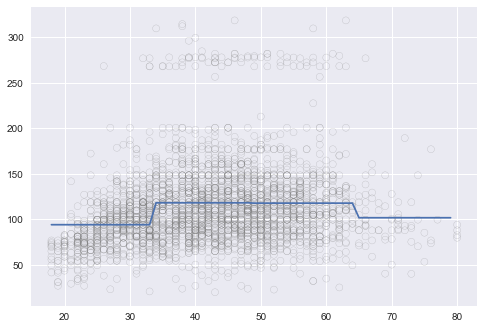

In [77]:
age_grid_bins = np.digitize(age_grid.ravel(), bins)

X_test = pd.get_dummies(age_grid_bins).drop(1, axis=1)

lin_pred = lr_step.predict(X_test)

plt.scatter(wage_step.age, wage.wage, marker='o', color='gray', alpha=0.5, facecolor='None')
plt.plot(age_grid, lin_pred);

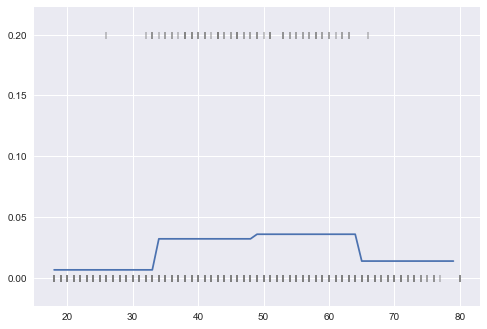

In [89]:
from statsmodels.formula.api import GLM

lr_sm = GLM(wage_step.wage_250, sm.add_constant(X),
            family=sm.families.Binomial(sm.families.links.logit)).fit()

log_pred = lr_sm.predict(sm.add_constant(X_test))

plt.scatter(wage_step.age, wage_step.wage_250/5, marker='|', color='gray', alpha=0.5)
plt.plot(age_grid, log_pred);

# 7.8.2 Splines